In [27]:
import numpy as np
from datetime import datetime
import ROOT
import math
import h5py
import xml.etree.ElementTree as ET
import os
import json
import argparse
import sys
phi_res = 128/(2*math.pi)

# --------------------------------------------------------------
# Constants
# --------------------------------------------------------------
# Maximum numbers of each object
NUM_JETS = 10
NUM_ELECTRONS = 6
NUM_MUONS = 6
NUM_PHOTONS = 6
NUM_L1 = 6

# Min/max pt and eta values
MIN_JET_PT = 0
MIN_PHELMU_PT = 0
MAX_ETA = 1000

# --------------------------------------------------------------
# Trigger Menu Stuff
# --------------------------------------------------------------
def get_hlt_chains_with_prescale_one(filename):
    # Open and load the JSON data
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Filter the entries that have "prescaleCombined" = 1
    result = []
    for item in data:
        if item.get('prescaleCombined') == 1:
            result.append(item['hltChain'])
    
    return result

def get_L1_chains_with_prescale_one(filename):
    # Open and load the JSON data
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Filter the entries that have "prescaleCombined" = 1
    result = []
    for item in data:
        if item.get('prescaleCombined') == 1:
            result.append(item['l1Item'])
    
    return np.unique(result)

HLT_trig_names = get_hlt_chains_with_prescale_one('/eos/home-m/mmcohen/gelato/trigger_menus/CombinedPrescale_l1_230_hlt_412.json')
L1_trig_names = get_L1_chains_with_prescale_one('/eos/home-m/mmcohen/gelato/trigger_menus/CombinedPrescale_l1_230_hlt_412.json')



# --------------------------------------------------------------
# Functions that read the TTree and make the data for HLTAD and L1AD
# --------------------------------------------------------------
def sort_and_pad(in_data, max_objects):
    """input an object of size (4, num_objects), as well as the maximum number of objects wanted.
    in_data[0] corresponds to the pt array, and the other three are E, eta, phi."""
    
    indices = np.argsort(in_data[0])[-max_objects:][::-1] # indices that sort the in_data by pt
    arrs = []
    for array in in_data:

        # Sorting
        sorted_arr = array[indices]

        # Padding
        if len(array) < max_objects:
            sorted_arr = np.concatenate((sorted_arr, np.zeros(max_objects - len(array))))

        arrs.append(sorted_arr)
        
    
    arrs = np.array(arrs).T
    return np.array(arrs)

def make_mask(min_pt, max_eta, pt, eta):
    """Make a mask on pt and eta of event, in case I want to make any data cuts."""

    return [(pt > MIN_JET_PT) and (abs(eta) < MAX_ETA) for pt, eta in zip(pt, eta)]


def get_data(event, c_name, vars=['pt', 'm', 'eta', 'phi'], mask=None):
    """
    Extracts and processes data from a specified container within an event.

    event: The event object containing the data.
    c_name: Name of the container to get the data from.
    vars: List of the variables to pull from the container.
    mask: The mask to apply to the data, if applicable.
    max_objects: Maximum number of objects to retain after sorting and padding.
    return: Processed data from the specified container, after being sorted and padded.
    """
    data = []
    for var in vars:
        full_var_name = f"{c_name}_{var}"
        var_data = getattr(event, full_var_name)

        if mask is not None:
            masked_data = np.asarray([x for x, m in zip(var_data, mask) if m])
        else:
            masked_data = np.asarray([x for x in var_data]) # for some reason this syntax runs way faster!?

        data.append(masked_data)
    return data
    #return sort_and_pad(data, max_objects=max_objects)


def make_ntuples(tree, use_TLA_triggers=True):
    if use_TLA_triggers == False:
        HLT_trig_names_ = [item for item in HLT_trig_names if 'TLA' not in item]
        L1_trig_names_ = [item for item in L1_trig_names if 'TLA' not in item]
    else:
        HLT_trig_names_ = HLT_trig_names
        L1_trig_names_ = L1_trig_names

    # Define lists to hold the data
    jet_list = []
    el_list = []
    muon_list = []
    ph_list = []
    MET_list = []
    pass_L1_unprescaled = []
    pass_HLT_unprescaled = []
    L1_muon_list = []
    L1_eFex_tau_list = []
    L1_MET_list = []
    L1_jFexSR_jet_list = []
    event_number_list = []
    run_number_list = []
    mu_list = []
    avg_int_list = []
    LB_list = []
    pass_single_jet_trigger = []
    HLT_unique_list = []
    L1_unique_list = []
    
    
    # loop over events in the TTree and save the info to the lists
    for i, event in enumerate(tree):

        # Trigger Decisions
        trig_data = [str(trigger) for trigger in event.passedTriggers]
        pass_L1_unprescaled.append(1*any(trigger in L1_trig_names_ for trigger in trig_data)) # 0=no 1=yes
        pass_HLT_unprescaled.append(1*any(trigger in HLT_trig_names_ for trigger in trig_data)) # 0=no 1=yes
        pass_single_jet_trigger.append('HLT_j400_pf_ftf_preselj225_L1jJ180' in trig_data)

        # Event/run number
        event_number_list.append(event.eventNumber)
        run_number_list.append(event.runNumber)
        LB_list.append(event.lumiBlock)


        if any('VAE' in item for item in trig_data):
            trig_data.remove("HLT_noalg_L1ADVAEL")
            trig_data.remove("L1_ADVAEL")
        
            # Check for other HLT triggers
            has_other_hlt = any('HLT' in item for item in trig_data)
            # Check for other L1 triggers  
            has_other_l1 = any('L1' in item for item in trig_data)
            
            # HLT_unique: no other HLT triggers (but L1 triggers allowed)
            HLT_unique_list.append(not has_other_hlt)
            
            # L1_unique: no other L1 triggers AND no other HLT triggers
            L1_unique_list.append(not has_other_l1 and not has_other_hlt)



        # Pileup
        mu_list.append(event.actualInteractionsPerCrossing)
        avg_int_list.append(event.averageInteractionsPerCrossing)
    
        # offline Jets
        jet_data = get_data(event, 'jet', vars=['pt', 'eta', 'phi'])
        jet_list.append(sort_and_pad(jet_data, max_objects=6))

    
        # Electrons
        el_data = get_data(event, 'electron', vars=['pt', 'eta', 'phi'])
        el_list.append(sort_and_pad(el_data, max_objects=3))
    
        # Muons
        muon_data = get_data(event, 'muon', vars=['pt', 'eta', 'phi'])
        muon_list.append(sort_and_pad(muon_data, max_objects=3))

        # Photons
        ph_data = get_data(event, 'photon', vars=['pt', 'eta', 'phi'])
        ph_list.append(sort_and_pad(ph_data, max_objects=3))


    print(sum)
    data = np.concatenate([np.array(jet_list), np.array(el_list), np.array(muon_list), np.array(ph_list)], axis=1)
    #u_mask = np.array(HLT_unique_list)
    
    #L1_u_mask = 

    #return data[~u_mask], data[u_mask]
    return data[np.array(HLT_unique_list)], data[~np.array(HLT_unique_list)], data[np.array(L1_unique_list)], data[~np.array(L1_unique_list)]


In [28]:
#ttree_file = '/eos/home-m/mmcohen/ad_trigger_development/ops/data/trees/user.mmcohen.data25_498007_ad_chain_06-11-2025_tree.root/user.mmcohen.00498007.45129233._000002.tree.root'
ttree_files = ['/eos/home-m/mmcohen/ad_trigger_development/ops/data/trees/user.mmcohen.data25_498007_ad_chain_06-22-2025_tree.root/user.mmcohen.00498007.45333880._000001.tree.root',
              '/eos/home-m/mmcohen/ad_trigger_development/ops/data/trees/user.mmcohen.data25_498007_ad_chain_06-22-2025_tree.root/user.mmcohen.00498007.45333880._000002.tree.root',
              '/eos/home-m/mmcohen/ad_trigger_development/ops/data/trees/user.mmcohen.data25_498007_ad_chain_06-22-2025_tree.root/user.mmcohen.00498007.45333880._000003.tree.root']

HLT_unique_data = []
HLT_overlap_data = []
L1_unique_data = []
L1_overlap_data = []

# Open the ROOT file and get the tree
for file in ttree_files:
    f = ROOT.TFile.Open(file)
    td = f.Get('output_tree')
    tree = td.Get("nominal")
    nevents = tree.GetEntries()
    print(f"Processing {nevents} events...")
    
    # Make the data
    _HLT_unique_data, _HLT_overlap_data, _L1_unique_data, _L1_overlap_data = make_ntuples(tree)
    
    HLT_unique_data.append(_HLT_unique_data)
    HLT_overlap_data.append(_HLT_overlap_data)
    L1_unique_data.append(_L1_unique_data)
    L1_overlap_data.append(_L1_overlap_data)

    

HLT_unique_data = np.vstack(HLT_unique_data)
HLT_overlap_data = np.vstack(HLT_overlap_data)
L1_unique_data = np.vstack(L1_unique_data)
L1_overlap_data = np.vstack(L1_overlap_data)


Processing 1293 events...
<built-in function sum>
Processing 4461 events...
<built-in function sum>
Processing 9512 events...
<built-in function sum>


In [29]:
print(HLT_unique_data.shape)
print(HLT_overlap_data.shape)
print(L1_unique_data.shape)
print(L1_overlap_data.shape)

(6571, 15, 3)
(8695, 15, 3)
(926, 15, 3)
(14340, 15, 3)


In [30]:
import matplotlib.pyplot as plt
# Thicker borders
plt.rcParams['axes.linewidth'] = 2.0

# Larger font sizes
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20

In [33]:
def hist_plot(data1: tuple, data2: tuple, data3: tuple, data4: tuple, bins, xlabel, log=True):
    """
    plots data1 and data2 in nice histograms.

    inputs:
    data1: tuple, (data, name)
    data2: tuple, (data, name)
    bins: np array with the histogram bins
    xlabel: string of the x label 
    """
    
    plt.figure(figsize=(12, 6))
    # plt.hist(data1[0], bins=bins, density=True, histtype='step', linewidth=2.5, fill=False, label=data1[1])
    # plt.hist(data2[0], bins=bins, density=True, histtype='step', linewidth=2.5, fill=False, label=data2[1])
    for data, label in [data1, data2, data3, data4]:
        plt.hist(data, bins=bins, density=True, histtype='step', linewidth=2.5, fill=False, label=label)
    plt.xlabel(xlabel)
    plt.yscale('log')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

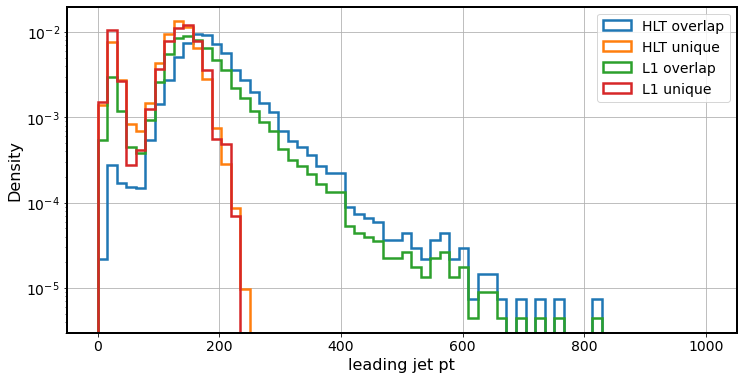

In [35]:
leading_jet_pt_1 = (HLT_overlap_data[:, 0, 0], 'HLT overlap')
leading_jet_pt_2 = (HLT_unique_data[:, 0, 0], 'HLT unique')
leading_jet_pt_3 = (L1_overlap_data[:, 0, 0], 'L1 overlap')
leading_jet_pt_4 = (L1_unique_data[:, 0, 0], 'L1 unique')

hist_plot(leading_jet_pt_1, leading_jet_pt_2, leading_jet_pt_3, leading_jet_pt_4, bins=np.linspace(0, 1000, 65), xlabel='leading jet pt')

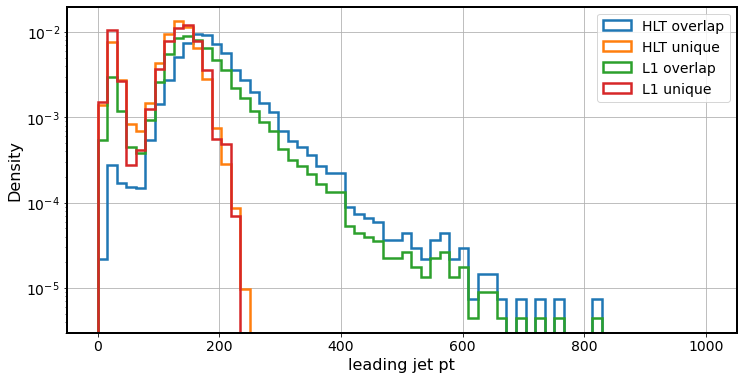

In [39]:
data_dict = {
    'HLT overlap': HLT_overlap_data,
    'HLT unique': HLT_unique_data,
    'L1 overlap': L1_overlap_data,
    'L1 unique': L1_unique_data
}

leading_jet_pts = [(data[:, 0, 0], label) for label, data in data_dict.items()]

hist_plot(*leading_jet_pts, bins=np.linspace(0, 1000, 65), xlabel='leading jet pt')

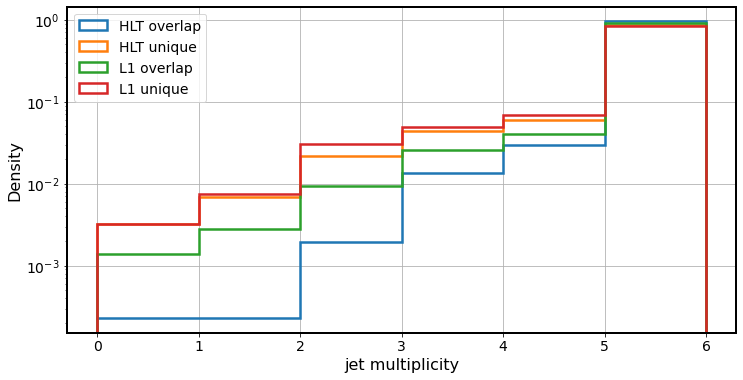

In [38]:
jet_mult_1 = (np.count_nonzero(HLT_overlap_data[:, :6, 0], axis=-1), 'HLT overlap')
jet_mult_2 = (np.count_nonzero(HLT_unique_data[:, :6, 0], axis=-1), 'HLT unique')
jet_mult_3 = (np.count_nonzero(L1_overlap_data[:, :6, 0], axis=-1), 'L1 overlap')
jet_mult_4 = (np.count_nonzero(L1_unique_data[:, :6, 0], axis=-1), 'L1 unique')

hist_plot(jet_mult_1, jet_mult_2, jet_mult_3, jet_mult_4, bins=np.arange(7), xlabel='jet multiplicity')